# RE19-linguistic-classification: performance evaluation

This notebook evaluates the performance of a F and Q requirements classifiers using different linguistic features.

## 0. Set up (optional)

Run the following install functions if running Jupyter on a cloud environment like Colaboratory, which does not allow you to install the libraries permanently on your local machine

In [1]:

!pip3 install mdlp-discretization
!pip3 install pysbrl==0.4.2rc0
!pip3 install cython numpy
!pip3 install skope-rules

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. Import libraries

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import ADASYN 

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_iris

import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import interp

import numpy as np
import pandas as pd

from skrules import SkopeRules

# Set the ipython display in such a way that helps the visualization of the rulematrix outputs.
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## 2. Auxiliary functions

In [12]:
def drop_descriptive_columns(dataset):
    """
    Removes from a dataset, descriptive columns before using it for training the classifiers
    @param dataset: the dataset enriched with features
    @return: the new 'cleaned' dataset
    """
    for c in dataset.columns:
        if c in ['RequirementText', 'Class', 'ProjectID']:
            dataset = dataset.drop(c, axis = 1)
    return dataset

def split_tr_te(dataset, target, to_drop):
    """
    Splits a dataset in training and test set (75 and 25%)
    @param dataset: the dataset to split
    @param target: the target class
    @param to_drop: some additional columns to drop before splitting
    @return: a tuple train_x, test_x, train_y, test_y, with y the target column, x the rest
    """
    return train_test_split(dataset.drop(to_drop, axis=1), dataset[target], test_size=0.25, random_state=42)
    
def print_scores(actual, pred, name, prob):
    """
    Prints the confusion matrix given the results of a classifier and calculates precision, recall, f1 and AUC score
    @param actual: the original annotation of the dataset (to use for the comparison in order to calculate the above metrics)
    @param pred: the predictions made by the classifier
    @param name: some textual variable to use for verbosity purposes
    @param prob: vector with the probabilities for the predictions in pred
    @return: a list [name, precision, recall, f1, auc]
    """
    f1 = f1_score(actual, pred, average='micro') 
    prec = precision_score(actual, pred) 
    rec = recall_score(actual, pred) 
    auc = roc_auc_score(actual, prob)
    print('=====', name)
    print('Confusion matrix (test)\n', confusion_matrix(actual, pred))
#     print('F1-Score (micro)', f1)
#     print('Precision', prec)
#     print('Recall (train)', rec, '\n')
    return [name, prec, rec, f1, auc]
    
  
def build_plot(y_true=[], scores=[], labels=[]):
    """
    Generates two plots: a roc plot and a preision/recall plot
    """
    gradient = np.linspace(0, 1, 10)
    color_list = [ cm.tab10(x) for x in gradient ]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5),
                         sharex=True, sharey=True)
    ax = axes[0]
    n_line = 0
    for i_score, score in enumerate(scores):
        fpr, tpr, _ = roc_curve(y_true[n_line], score, drop_intermediate=False)
        n_line = n_line + 1
        ax.plot(fpr, tpr, linestyle='-.', c=color_list[i_score], lw=1, label=labels[i_score])
    ax.set_title("ROC", fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=18)
    ax.set_ylabel('True Positive Rate (Recall)', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)

    ax = axes[1]
    n_line = 0
    for i_score, score in enumerate(scores):
        precision, recall, _ = precision_recall_curve(y_true[n_line], score)
        n_line = n_line + 1
        ax.step(recall, precision, linestyle='-.', c=color_list[i_score], lw=1, where='post', label=labels[i_score])
    ax.set_title("Precision-Recall", fontsize=20)
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=18)
    ax.set_ylabel('Precision', fontsize=18)
    ax.legend(loc='lower center', fontsize=8)
    plt.show()

        
def train_classifier(model, train_x, train_y, name):
    """
    Train a classifier and returns the fit scores for the training set
    """
    model.fit(train_x, train_y)
    pred_train = model.predict(train_x)
    prob = model.predict_proba(train_x)[:, 1]
    scores_line = print_scores(train_y, pred_train, name, prob)
    return scores_line, pred_train, prob
  
def evaluate_classifier(model, test_x, test_y, name):
    """
    Executes the classifiers on the test set and returns the obtained scores
    """
    pred_test = model.predict(test_x)
    prob = model.predict_proba(test_x)[:, 1]
    scores_line = print_scores(test_y, pred_test, name, prob)
    return scores_line, pred_test, prob
  
def makeOverSamplesADASYN(X,y):
  """
  Creates new data with oversampled variables by using ADASYN
  @param X: Independent Variable in DataFrame
  @param y: dependent variable in Pandas DataFrame formats
  @return: an oversampled version of the variables
  """
  sm = ADASYN()
  X, y = sm.fit_sample(X, y)
  return X, y

def make_roc_curve(appendix, target, to_drop, golds, probs, names, scores, nrfeat, colors):
  """
  Generates a ROC plot (used in the paper)
  """
  cv = StratifiedKFold(n_splits=10)
  #classifier = svm.SVC(kernel='linear', probability=True, random_state=0)
  #classifier = RandomForestClassifier()
  #classifier = GaussianNB()
  #classifier = KNeighborsClassifier()
  classifier = MultinomialNB()
  #classifier = DecisionTreeClassifier()
  #classifier = LogisticRegression()
  # For fast processing
  # from sklearn.ensemble import GradientBoostingClassifier
  # classifier = GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth = 5)

  tprs = []
  aucs = []
  paucs = []
  ptprs = []
  mean_fpr = np.linspace(0, 1, 100)
  pmean_fpr = np.linspace(0, 1, 100)

  plt.figure(figsize=(10,6))

  dataz = pd.read_csv(folder_datasets+'promise-reclass' + '-' + appendix + '.csv', engine='python')

  # Attempt with project-based fold -- TODO: try another partitioning
  # projects = [[3, 9, 11], [1, 5, 12], [6, 10, 13], [1, 8, 14], [3, 10, 12], [2, 5, 11], [4, 6, 14], [7, 8, 13], [2, 9, 15], [4, 7, 15] ]
  projects = [[3, 9, 11], [1, 5, 12], [6, 10, 13], [1, 8, 14], [3, 12, 15], [2, 5, 11], [6, 9, 14], [7, 8, 13], [2, 4, 15], [4, 7, 10] ]
  
  print (target + 'p-fold')
  prec = 0.0
  rec = 0.0
  f1 = 0.0
  for k in projects:
    mytest = dataz.loc[dataz['ProjectID'].isin(k)]
    mytrain = dataz.loc[~dataz['ProjectID'].isin(k)]
    mytest = drop_descriptive_columns(mytest)
    mytest = mytest.drop(mytest.columns[0], axis=1)
    mytrain = drop_descriptive_columns(mytrain)
    mytrain = mytrain.drop(mytrain.columns[0], axis=1)
    myprobs = classifier.fit(mytrain.drop(to_drop, axis=1), 
                             mytrain[target]).predict_proba(mytest.drop(to_drop, axis=1))
    pred = classifier.predict(mytest.drop(to_drop, axis=1))
    prec += precision_score(mytest[target].values.tolist(), pred) 
    rec += recall_score(mytest[target].values.tolist(), pred)
    f1 += f1_score(mytest[target].values.tolist(), pred)
    print (k, 'Precision', prec, 'Recall', rec )
    myfpr, mytpr, _ = roc_curve(mytest[target].values.tolist(), myprobs[:, 1], drop_intermediate=False)
    ptprs.append(interp(pmean_fpr, myfpr, mytpr))
    ptprs[-1][0] = 0.0
    my_auc = auc(myfpr, mytpr)
#     my_auc = roc_auc_score(mytest[target].values.tolist(), myprobs[:, 1])
    paucs.append(my_auc)
    plt.plot(myfpr, mytpr, lw=1, color=colors['Promise test'], alpha=0.8, linestyle='--',
                 label='Projects bundle %s (AUC = %0.2f)' % (str(k), my_auc))

  print ('p-fold', 'Precision', str(prec/10.0), 'Recall', str(rec/10.0), 'F1', str(f1/10.0), 'AUC', str(my_auc/10.0))  

  pmean_tpr = np.mean(ptprs, axis=0)
  pmean_tpr[-1] = 1.0
#   pmean_auc = auc(pmean_fpr, pmean_tpr)
  pmean_auc = np.mean(paucs, axis=0)
  std_auc = np.std(paucs)
  plt.plot(pmean_fpr, pmean_tpr, color=colors['Promise test'], linestyle='--',
           label=r'Mean p-fold (AUC = %0.2f $\pm$ %0.2f)' % (pmean_auc, std_auc),
           lw=2, alpha=.8)

  std_tpr = np.std(ptprs, axis=0)
  tprs_upper = np.minimum(pmean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(pmean_tpr - std_tpr, 0)
  plt.fill_between(pmean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                   label=r'$\pm$ 1 std. dev. from p-fold')
  
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

  plt.figure(figsize=(10,6))
  
  dataz = drop_descriptive_columns(dataz)
  dataz = dataz.drop(dataz.columns[0], axis=1)

  X = dataz.drop(to_drop, axis=1)
  y = dataz[target]

  # This code plots the ROC curve with cross validation
  print (target + 'k-fold')
  i = 0
  prec = 0.0
  rec = 0.0
  f1 = 0.0
  for train, test in cv.split(X, y):
      probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
      pred = classifier.predict(X.iloc[test])
      prec += precision_score(y.iloc[test], pred) 
      rec += recall_score(y.iloc[test], pred)
      f1 += f1_score(y.iloc[test], pred)
      print (i, 'Precision', prec, 'Recall', rec )
      # Compute ROC curve and area the curve
      fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1], drop_intermediate=False)
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      roc_auc = auc(fpr, tpr)
#       roc_auc = roc_auc_score(y.iloc[test], probas_[:, 1])
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=1, alpha=0.3,
               label='k-fold %d (AUC = %0.2f)' % (i, roc_auc))
      i += 1

  print ('k-fold', 'Precision', str(prec/10.0), 'Recall', str(rec/10.0), 'F1', str(f1/10.0), 'AUC', str(roc_auc/10))

  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#          label='Chance', alpha=.8)

  plt.plot(pmean_fpr, pmean_tpr, color=colors['Promise test'], linestyle=':',
           label=r'Mean p-fold (AUC = %0.2f $\pm$ %0.2f)' % (pmean_auc, std_auc),
           lw=2, alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
#   mean_auc = auc(mean_fpr, mean_tpr)
  mean_auc = np.mean(aucs, axis=0)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color=colors['Promise test'], linestyle='--',
           label=r'Mean k-fold (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
           lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                   label=r'$\pm$ 1 std. dev. from k-fold')


  idx = 0
  #colors = ['green', 'brown', 'darkolivegreen', 'purple', 'yellow', 'black', 'red', 'peru']
  for gold in golds:
    fpr, tpr, thresholds = roc_curve(gold, probs[idx])
#     the_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, color=colors[names[idx]], alpha=0.8,
               label='%s (AUC = %0.2f)' % (names[idx], scores[idx]))
    idx += 1


  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  #plt.legend(loc="lower right")

  handles, labels = plt.gca().get_legend_handles_labels()
  order = [2, 1, 0]
  
  for i in range(3, len(handles)):
    order.append(i)
  
  print ('The order is', order)
  plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

  #plt.show()
  print ('roc-' + str(nrfeat) + '-' + appendix + '.pdf')
  plt.savefig('roc-' + str(nrfeat) + '-' + appendix + '.pdf', dpi=300, bbox_inches='tight')

## 3a. Precision, recall, F1, ROC curve

Imports the classified and **enriched** dataset, calculates precision, recall, F1 score and plots the ROC curve

======== Results for feature set 'FinalSel' with target 'IsFunctional' ========
===== Promise train
Confusion matrix (test)
 [[116 116]
 [ 48 188]]
===== Promise test
Confusion matrix (test)
 [[44 39]
 [16 58]]
['Promise test', 0.5979381443298969, 0.7837837837837838, 0.6496815286624203, 0.7097036795831977]
esa-eucl-est
===== esa-eucl-est
Confusion matrix (test)
 [[79 66]
 [35 56]]
ds2
===== ds2
Confusion matrix (test)
 [[  8  21]
 [ 10 133]]
ds3
Oversampling ds3
===== ds3
Confusion matrix (test)
 [[ 39  85]
 [ 23 103]]
dronology
===== dronology
Confusion matrix (test)
 [[ 0  3]
 [17 77]]
reqview
===== reqview
Confusion matrix (test)
 [[ 7  5]
 [ 5 70]]
leeds
===== leeds
Confusion matrix (test)
 [[14 27]
 [ 6 38]]
wasp
===== wasp
Confusion matrix (test)
 [[ 5  2]
 [17 38]]
Feature set 'FinalSel' Target 'IsFunctional' ========


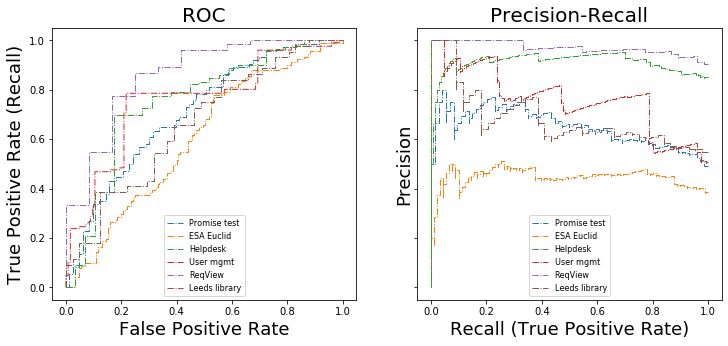

IsFunctionalp-fold
[3, 9, 11] Precision 0.717948717948718 Recall 0.8615384615384616
[1, 5, 12] Precision 1.3395703395703396 Recall 1.5802884615384616
[6, 10, 13] Precision 1.9666889836381363 Recall 2.060807942057942
[1, 8, 14] Precision 2.4200223169714694 Recall 2.627474608724609
[3, 12, 15] Precision 3.0200223169714695 Recall 3.4199274389132883
[2, 5, 11] Precision 3.682359979309132 Recall 4.242508084074578
[6, 9, 14] Precision 4.287623137203869 Recall 5.144468868388304
[7, 8, 13] Precision 4.721833663519658 Recall 5.733754582674019
[2, 4, 15] Precision 5.274072469489807 Recall 6.504587916007352
[4, 7, 10] Precision 5.944402139819478 Recall 7.230778392197828
p-fold Precision 0.5944402139819478 Recall 0.7230778392197827 F1 0.6479475146385878 AUC 0.052330293819655524


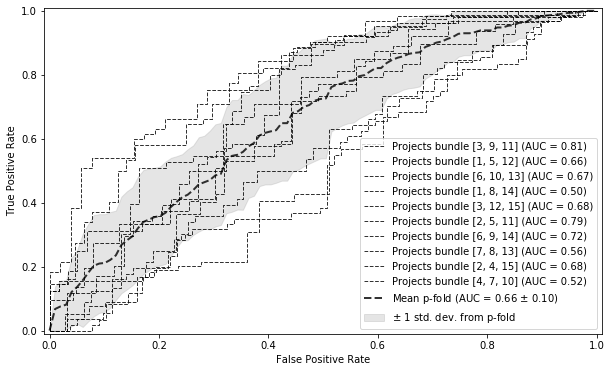

IsFunctionalk-fold
0 Precision 0.65625 Recall 0.6774193548387096
1 Precision 1.19625 Recall 1.5483870967741935
2 Precision 1.7676785714285714 Recall 2.4516129032258065
3 Precision 2.2954563492063493 Recall 3.064516129032258
4 Precision 3.0176785714285717 Recall 3.903225806451613
5 Precision 3.7153529900332227 Recall 4.870967741935484
6 Precision 4.199223957775159 Recall 5.35483870967742
7 Precision 4.777001735552936 Recall 6.193548387096775
8 Precision 5.527001735552936 Recall 7.064516129032259
9 Precision 6.0911042996555 Recall 7.774193548387098
k-fold Precision 0.60911042996555 Recall 0.7774193548387098 F1 0.6790050798116581 AUC 0.05910509885535901


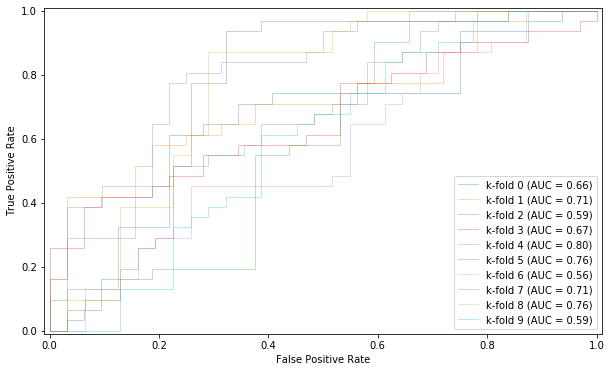

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8]
roc--ling-FinalSel.pdf


,Dataset,Prec-ling-FinalSel,Rec-ling-FinalSel,F1-ling-FinalSel,AUC-ling-FinalSel
0,Promise test,0.598,0.784,0.650,0.710
1,esa-eucl-est,0.459,0.615,0.572,0.604
2,ds2,0.864,0.930,0.820,0.754
3,ds3,0.548,0.817,0.568,0.753
4,dronology,0.963,0.819,0.794,0.454
5,reqview,0.933,0.933,0.885,0.860
6,leeds,0.585,0.864,0.612,0.665
7,wasp,0.950,0.691,0.694,0.722
8,Macro-average,0.757,0.810,0.706,0.687
9,Std-dev,0.201,0.110,0.119,0.121


Done Innerrrr
======== Results for feature set 'FinalSel' with target 'IsQuality' ========
===== Promise train
Confusion matrix (test)
 [[153  34]
 [114 167]]
===== Promise test
Confusion matrix (test)
 [[48  8]
 [43 58]]
['Promise test', 0.8787878787878788, 0.5742574257425742, 0.6751592356687898, 0.7735148514851485]
esa-eucl-est
===== esa-eucl-est
Confusion matrix (test)
 [[ 12  13]
 [ 63 148]]
ds2
===== ds2
Confusion matrix (test)
 [[107  14]
 [ 33  18]]
ds3
===== ds3
Confusion matrix (test)
 [[80 33]
 [ 9 16]]
dronology
===== dronology
Confusion matrix (test)
 [[27 42]
 [10 18]]
reqview
===== reqview
Confusion matrix (test)
 [[42 13]
 [19 13]]
leeds
===== leeds
Confusion matrix (test)
 [[12 12]
 [29 32]]
wasp
===== wasp
Confusion matrix (test)
 [[21 22]
 [ 8 11]]
Feature set 'FinalSel' Target 'IsQuality' ========


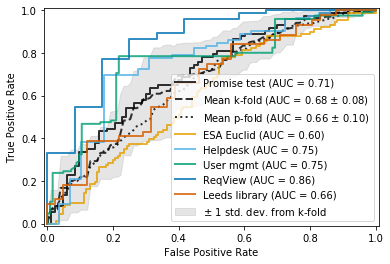

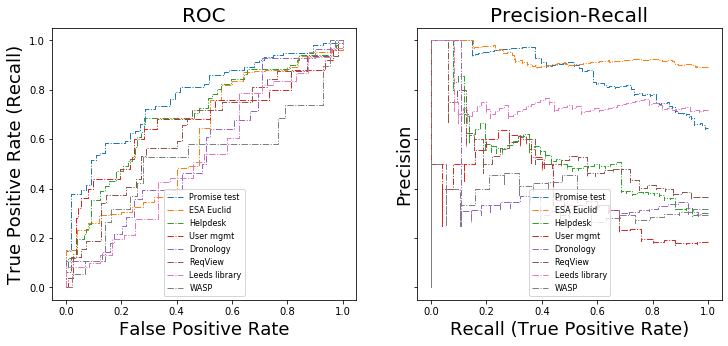

IsQualityp-fold
[3, 9, 11] Precision 0.5487804878048781 Recall 0.8490566037735849
[1, 5, 12] Precision 1.3068450039339103 Recall 1.48419173890872
[6, 10, 13] Precision 1.879572276661183 Recall 2.2524844218355495
[1, 8, 14] Precision 2.6822038556085515 Recall 2.8447174315442876
[3, 12, 15] Precision 3.269160377347682 Recall 3.650687580798019
[2, 5, 11] Precision 4.133567157008699 Recall 4.321740212376966
[6, 9, 14] Precision 5.005907582540614 Recall 4.907454498091251
[7, 8, 13] Precision 5.878923455556487 Recall 5.446670184365761
[2, 4, 15] Precision 6.71225678888982 Recall 6.046670184365761
[4, 7, 10] Precision 7.21225678888982 Recall 6.466025023075438
p-fold Precision 0.721225678888982 Recall 0.6466025023075438 F1 0.6651794358642593 AUC 0.054932211313697986


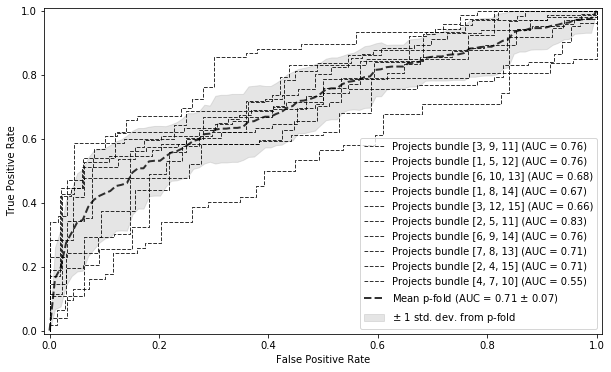

IsQualityk-fold
0 Precision 0.8157894736842105 Recall 0.7948717948717948
1 Precision 1.5254668930390491 Recall 1.358974358974359
2 Precision 2.1921335597057157 Recall 1.885290148448043
3 Precision 2.8958372634094194 Recall 2.385290148448043
4 Precision 3.8291705967427525 Recall 3.122132253711201
5 Precision 4.792133559705715 Recall 3.8063427800269904
6 Precision 5.667133559705715 Recall 4.358974358974359
7 Precision 6.389355781927938 Recall 4.701079622132253
8 Precision 7.210784353356509 Recall 5.3063427800269904
9 Precision 8.085784353356509 Recall 5.858974358974359
k-fold Precision 0.8085784353356509 Recall 0.5858974358974358 F1 0.6746240445196803 AUC 0.0700657894736842


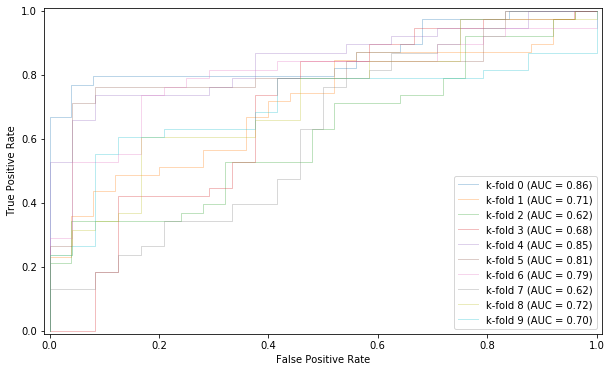

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10]
roc--ling-FinalSel.pdf


,Dataset,Prec-ling-FinalSel,Rec-ling-FinalSel,F1-ling-FinalSel,AUC-ling-FinalSel
0,Promise test,0.879,0.574,0.675,0.774
1,esa-eucl-est,0.919,0.701,0.678,0.608
2,ds2,0.562,0.353,0.727,0.697
3,ds3,0.327,0.640,0.696,0.667
4,dronology,0.300,0.643,0.464,0.557
5,reqview,0.500,0.406,0.632,0.632
6,leeds,0.727,0.525,0.518,0.527
7,wasp,0.333,0.579,0.516,0.517
8,Macro-average,0.524,0.550,0.604,0.601
9,Std-dev,0.216,0.120,0.096,0.065


Done Innerrrr
======== Results for feature set 'FinalSel' with target 'OnlyFunctional' ========
===== Promise train
Confusion matrix (test)
 [[178 114]
 [ 42 134]]
===== Promise test
Confusion matrix (test)
 [[63 40]
 [13 41]]
['Promise test', 0.5061728395061729, 0.7592592592592593, 0.6624203821656051, 0.7817331895001798]
esa-eucl-est
===== esa-eucl-est
Confusion matrix (test)
 [[116  29]
 [ 61  30]]
ds2
===== ds2
Confusion matrix (test)
 [[ 15  14]
 [ 29 114]]
ds3
===== ds3
Confusion matrix (test)
 [[ 9  3]
 [76 50]]
dronology
===== dronology
Confusion matrix (test)
 [[ 2  1]
 [72 22]]
reqview
===== reqview
Confusion matrix (test)
 [[11  1]
 [35 40]]
leeds
===== leeds
Confusion matrix (test)
 [[36  5]
 [28 16]]
wasp
===== wasp
Confusion matrix (test)
 [[ 6  1]
 [40 15]]
Feature set 'FinalSel' Target 'IsFunctional' ========


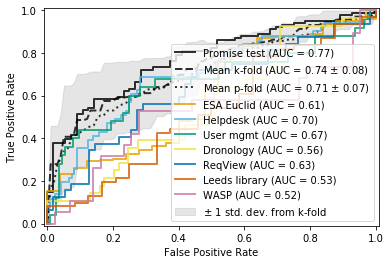

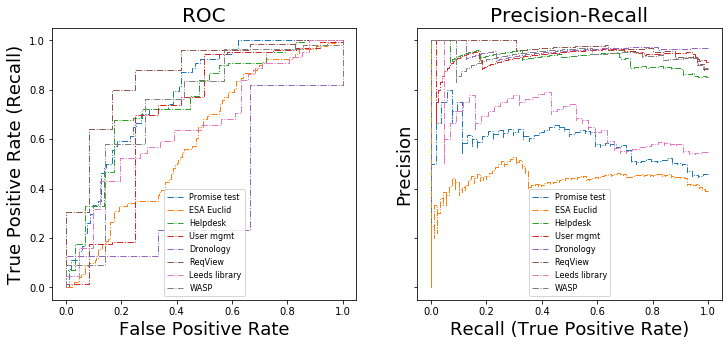

IsFunctionalp-fold
[3, 9, 11] Precision 0.717948717948718 Recall 0.8615384615384616
[1, 5, 12] Precision 1.3395703395703396 Recall 1.5802884615384616
[6, 10, 13] Precision 1.9666889836381363 Recall 2.060807942057942
[1, 8, 14] Precision 2.4200223169714694 Recall 2.627474608724609
[3, 12, 15] Precision 3.0200223169714695 Recall 3.4199274389132883
[2, 5, 11] Precision 3.682359979309132 Recall 4.242508084074578
[6, 9, 14] Precision 4.287623137203869 Recall 5.144468868388304
[7, 8, 13] Precision 4.721833663519658 Recall 5.733754582674019
[2, 4, 15] Precision 5.274072469489807 Recall 6.504587916007352
[4, 7, 10] Precision 5.944402139819478 Recall 7.230778392197828
p-fold Precision 0.5944402139819478 Recall 0.7230778392197827 F1 0.6479475146385878 AUC 0.052330293819655524


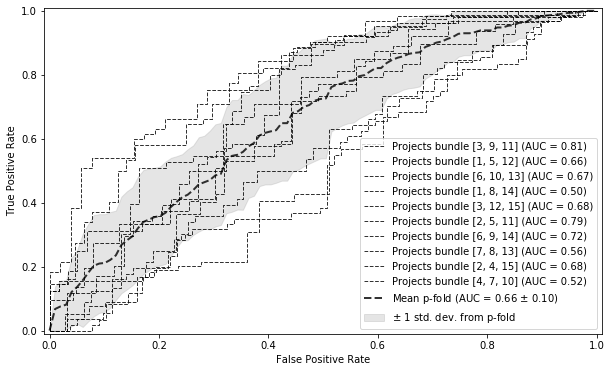

IsFunctionalk-fold
0 Precision 0.65625 Recall 0.6774193548387096
1 Precision 1.19625 Recall 1.5483870967741935
2 Precision 1.7676785714285714 Recall 2.4516129032258065
3 Precision 2.2954563492063493 Recall 3.064516129032258
4 Precision 3.0176785714285717 Recall 3.903225806451613
5 Precision 3.7153529900332227 Recall 4.870967741935484
6 Precision 4.199223957775159 Recall 5.35483870967742
7 Precision 4.777001735552936 Recall 6.193548387096775
8 Precision 5.527001735552936 Recall 7.064516129032259
9 Precision 6.0911042996555 Recall 7.774193548387098
k-fold Precision 0.60911042996555 Recall 0.7774193548387098 F1 0.6790050798116581 AUC 0.05910509885535901


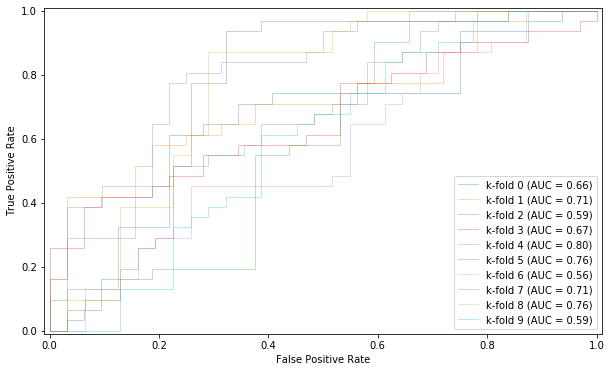

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8, 9, 10]
roc--ling-FinalSel.pdf


,Dataset,Prec-ling-FinalSel,Rec-ling-FinalSel,F1-ling-FinalSel,AUC-ling-FinalSel
0,Promise test,0.506,0.759,0.662,0.782
1,esa-eucl-est,0.508,0.330,0.619,0.603
2,ds2,0.891,0.797,0.750,0.755
3,ds3,0.943,0.397,0.428,0.696
4,dronology,0.957,0.234,0.247,0.394
5,reqview,0.976,0.533,0.586,0.863
6,leeds,0.762,0.364,0.612,0.661
7,wasp,0.938,0.273,0.339,0.740
8,Macro-average,0.853,0.418,0.511,0.673
9,Std-dev,0.156,0.179,0.165,0.137


Done Innerrrr
======== Results for feature set 'FinalSel' with target 'OnlyQuality' ========
===== Promise train
Confusion matrix (test)
 [[199  48]
 [109 112]]
===== Promise test
Confusion matrix (test)
 [[59 17]
 [38 43]]
['Promise test', 0.7166666666666667, 0.5308641975308642, 0.6496815286624203, 0.7123131903833658]
esa-eucl-est
===== esa-eucl-est
Confusion matrix (test)
 [[ 13  12]
 [114  97]]
ds2
===== ds2
Confusion matrix (test)
 [[116   5]
 [ 41  10]]
ds3
Oversampling ds3
===== ds3
Confusion matrix (test)
 [[103  10]
 [ 86  30]]
dronology
===== dronology
Confusion matrix (test)
 [[59 10]
 [24  4]]
reqview
===== reqview
Confusion matrix (test)
 [[51  4]
 [26  6]]
leeds
===== leeds
Confusion matrix (test)
 [[18  6]
 [48 13]]
wasp
===== wasp
Confusion matrix (test)
 [[30 13]
 [10  9]]
Feature set 'FinalSel' Target 'IsQuality' ========


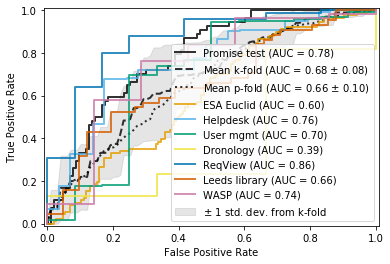

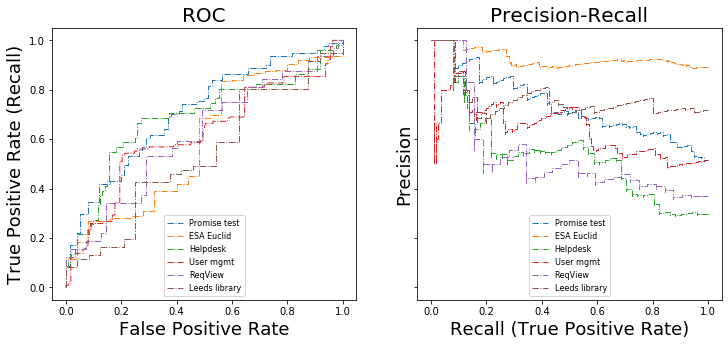

IsQualityp-fold
[3, 9, 11] Precision 0.5487804878048781 Recall 0.8490566037735849
[1, 5, 12] Precision 1.3068450039339103 Recall 1.48419173890872
[6, 10, 13] Precision 1.879572276661183 Recall 2.2524844218355495
[1, 8, 14] Precision 2.6822038556085515 Recall 2.8447174315442876
[3, 12, 15] Precision 3.269160377347682 Recall 3.650687580798019
[2, 5, 11] Precision 4.133567157008699 Recall 4.321740212376966
[6, 9, 14] Precision 5.005907582540614 Recall 4.907454498091251
[7, 8, 13] Precision 5.878923455556487 Recall 5.446670184365761
[2, 4, 15] Precision 6.71225678888982 Recall 6.046670184365761
[4, 7, 10] Precision 7.21225678888982 Recall 6.466025023075438
p-fold Precision 0.721225678888982 Recall 0.6466025023075438 F1 0.6651794358642593 AUC 0.054932211313697986


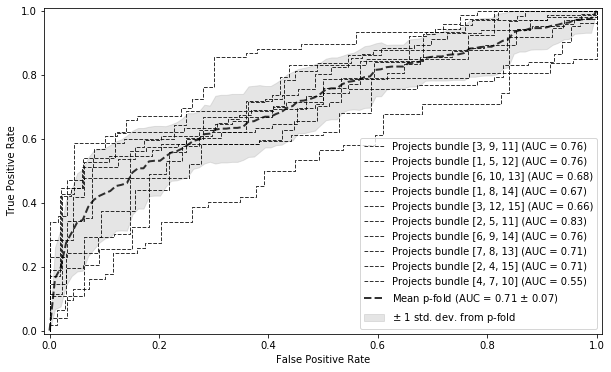

IsQualityk-fold
0 Precision 0.8157894736842105 Recall 0.7948717948717948
1 Precision 1.5254668930390491 Recall 1.358974358974359
2 Precision 2.1921335597057157 Recall 1.885290148448043
3 Precision 2.8958372634094194 Recall 2.385290148448043
4 Precision 3.8291705967427525 Recall 3.122132253711201
5 Precision 4.792133559705715 Recall 3.8063427800269904
6 Precision 5.667133559705715 Recall 4.358974358974359
7 Precision 6.389355781927938 Recall 4.701079622132253
8 Precision 7.210784353356509 Recall 5.3063427800269904
9 Precision 8.085784353356509 Recall 5.858974358974359
k-fold Precision 0.8085784353356509 Recall 0.5858974358974358 F1 0.6746240445196803 AUC 0.0700657894736842


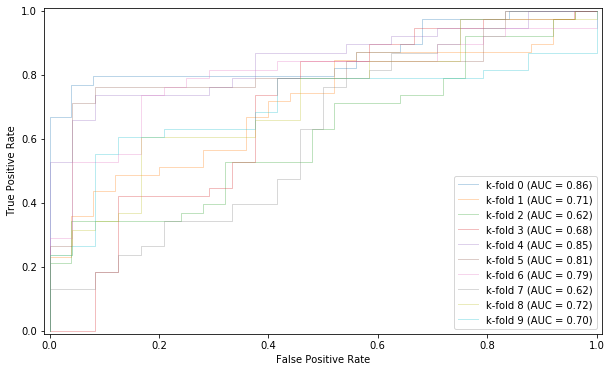

The order is [2, 1, 0, 3, 4, 5, 6, 7, 8]
roc--ling-FinalSel.pdf


,Dataset,Prec-ling-FinalSel,Rec-ling-FinalSel,F1-ling-FinalSel,AUC-ling-FinalSel
0,Promise test,0.717,0.531,0.650,0.712
1,esa-eucl-est,0.890,0.460,0.466,0.592
2,ds2,0.667,0.196,0.733,0.687
3,ds3,0.750,0.259,0.581,0.617
4,dronology,0.286,0.143,0.649,0.580
5,reqview,0.600,0.188,0.655,0.612
6,leeds,0.684,0.213,0.365,0.536
7,wasp,0.409,0.474,0.629,0.528
8,Macro-average,0.612,0.276,0.583,0.593
9,Std-dev,0.190,0.125,0.117,0.050


Done Innerrrr


,Dataset,Prec-ling-FinalSel_x,Rec-ling-FinalSel_x,F1-ling-FinalSel_x,AUC-ling-FinalSel_x,Prec-ling-FinalSel_y,Rec-ling-FinalSel_y,F1-ling-FinalSel_y,AUC-ling-FinalSel_y,Prec-ling-FinalSel_x,Rec-ling-FinalSel_x,F1-ling-FinalSel_x,AUC-ling-FinalSel_x,Prec-ling-FinalSel_y,Rec-ling-FinalSel_y,F1-ling-FinalSel_y,AUC-ling-FinalSel_y
0,Promise test,0.598,0.784,0.650,0.710,0.879,0.574,0.675,0.774,0.506,0.759,0.662,0.782,0.717,0.531,0.650,0.712
1,Macro-average,0.757,0.810,0.706,0.687,0.524,0.550,0.604,0.601,0.853,0.418,0.511,0.673,0.612,0.276,0.583,0.593


Done Inner
Done


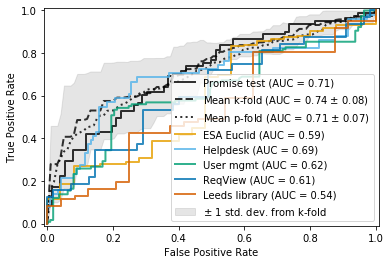

In [13]:
folder_datasets = '/Users/westerops/Desktop/cmpe/cmpe492/RE-2019-Materials/Datasets with features/' #can be an url
filenames = ['esa-eucl-est', 'ds2', 'ds3', 'dronology', 'reqview', 'leeds', 'wasp']
labels = ['ESA Euclid', 'Helpdesk', 'User mgmt', 'Dronology', 'ReqView', 'Leeds library', 'WASP']
remove = [('dronology', 'f'),('dronology', 'oq'),('wasp', 'f'),('wasp', 'oq')]
oversample = [('ds3', 'f'), ('ds3', 'oq')]
targets = ['IsFunctional', 'IsQuality', 'OnlyFunctional', 'OnlyQuality']

colorpalette = ['#000000', '#e69f00', '#56b4e9', '#009e73', '#f0e442', '#0072b2', '#d55e00', '#cc79a7']
colors = {'Promise test' : colorpalette[0]}
for i in range(0, len(filenames)):
  colors.update({labels[i] : colorpalette[i+1]})

pd.set_option('precision', 3)

allfiles = ['Promise train', 'Promise test', 'Macro-average', 'Micro-average']
allfiles += labels
allresults = pd.DataFrame(allfiles, columns = ['Dataset']) 

feature_sets = ['FinalSel']



# classify all datasets with all possible feature sets and for all target class.
# print the results and the plots
for feature_set in feature_sets:
  for target in targets:
    print("======== Results for feature set '"+feature_set+"' with target '"+ target +"' ========")

    to_drop = ['IsFunctional', 'IsQuality']

    appendix = 'ling-'+feature_set
    
    #read the promise dataset, it is used to train the classifier, which will be then tested on all other datasets
    data = pd.read_csv(folder_datasets+'promise-reclass' + '-' + appendix + '.csv', engine='python')
    
    tag = ''
    if target=='IsFunctional':
      tag = 'f'
    if target=='IsQuality':
      tag = 'q'
    if target=='OnlyFunctional':
      tag = 'of'
      data['IsFunctional'] = data['IsFunctional'] & ~data['IsQuality'] #calculating the right value for the column
      target = 'IsFunctional'
    if target=='OnlyQuality':
      tag = 'oq'
      data['IsQuality'] = ~data['IsFunctional'] & data['IsQuality']
      target = 'IsQuality'

   
    probs = []
    names = []
    golds = []
    auc_scores = []
    
    data = drop_descriptive_columns(data)
    
    #split promise in 75/25
    train_x, test_x, train_y, test_y = split_tr_te(data, target, to_drop) 
    res = []
    #train the classifier on the 75% of promise
    #model = SVC(kernel='linear', C=1, random_state=0, probability=True)
    #model = RandomForestClassifier()
    #model = GaussianNB()
    #model = KNeighborsClassifier()
    model = MultinomialNB()
    #model = LogisticRegression()
    #model = DecisionTreeClassifier()
    scores_line, _, _ = train_classifier(model, train_x, train_y, 'Promise train') 
    #test the performances on the remaining 25
    scores_line, svm_te, svm_pr = evaluate_classifier(model, test_x, test_y, 'Promise test')
    print (scores_line)
    res.append(scores_line)
    probs.append(svm_pr)
    names.append('Promise test')
    golds.append(test_y)
    auc_scores.append(scores_line[4])
    
    #retrain the classifier on entire promise and test it on the other datasets
    model.fit(data.drop(to_drop, axis=1), data[target])
    
    precisions = []
    recalls = []
    f1s = []
    aucs = []
    idx = 0
    for filename in filenames: #loop for all datasets
      print(filename)
      data3 = pd.read_csv(folder_datasets+filename + '-' + appendix + '.csv', engine='python')
      if target == 'OnlyQuality':
        data3['IsQuality'] = ~data3['IsFunctional'] & data3['IsQuality']
        target = 'IsQuality'

      if target == 'OnlyFunctional':
        data3['IsFunctional'] = data3['IsFunctional'] & ~data3['IsQuality']
        target = 'IsFunctional'
        
      data3 = drop_descriptive_columns(data3)
      if (filename, tag) in oversample:
        print ('Oversampling', filename)
        X, y = makeOverSamplesADASYN(data3.drop(to_drop, axis=1), data3[target])
      else:
        X = data3.drop(to_drop, axis=1)
        y = data3[target]
      scores_line, svm_te, svm_pr = evaluate_classifier(model, X, y, filename)
      precisions.append(scores_line[1])
      recalls.append(scores_line[2])
      f1s.append(scores_line[3])
      aucs.append(scores_line[4])
      res.append(scores_line)
      if (filename, tag) not in remove:
        probs.append(svm_pr)
        names.append(labels[idx])
        auc_scores.append(scores_line[4])
        if (filename, tag) in oversample:
          golds.append(y)
        else:
          golds.append(y.values.tolist())
      idx = idx + 1
      
    res.append(['Macro-average', np.mean(precisions), np.mean(recalls), np.mean(f1s), np.mean(aucs)])
    res.append(['Std-dev', np.std(precisions), np.std(recalls), np.std(f1s), np.std(aucs)])

    print("Feature set '"+feature_set+"' Target '"+ target +"' ========")
    
    #display the results in the form of tables precision recall f1 auc, plots
    build_plot(y_true=golds, scores=probs, labels=names)
    make_roc_curve(appendix, target, to_drop, golds, probs, names, auc_scores, '', colors)  
    results = pd.DataFrame(res, columns = ['Dataset', 'Prec-' + appendix, 'Rec-' + appendix, 'F1-' + appendix, 'AUC-' + appendix]) 
    display(HTML(results.to_html()))

    allresults = pd.merge(allresults, results, on='Dataset')
    print ('Done Innerrrr')

  display(HTML(allresults.to_html()))
  print ('Done Inner')



print ('Done')


